In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler

In [197]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

## 1. Cleaning Data and Getting relevant features

#### Joining both sets for easier analysis, storing SalePrice column for later use

In [198]:
target = df_train[['SalePrice']]
df_train.drop(columns='SalePrice', inplace = True)

In [199]:
df = pd.concat([df_train, df_test])
df = df.select_dtypes(exclude=['object'])

#### Removing features that have the most missing values, they are irrelevant.

In [200]:
nulldf = (df.isnull().sum() * 100 / len(dataset))[df.isnull().sum() > 0].sort_values().to_frame().rename(columns={0:"% missing"})
nulldf

,% missing
BsmtFinSF1,0.034258
BsmtFinSF2,0.034258
BsmtUnfSF,0.034258
TotalBsmtSF,0.034258
GarageCars,0.034258
GarageArea,0.034258
BsmtFullBath,0.068517
BsmtHalfBath,0.068517
MasVnrArea,0.787941
GarageYrBlt,5.447071


In [201]:
df.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"], inplace=True)

#### Filling in the rest of the features that have null values with zeros. (other values such as the median can work here too)

In [202]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea','BsmtFullBath', 'BsmtHalfBath']:
    df[col] = df[col].fillna(0)
    #df[col] = df[col].fillna(df[col].median)
    

#### Adding back the SalePrice column and splitting them back into two dataframes

In [221]:
train_df = pd.concat([df.iloc[:len(target["SalePrice"]),:],target['SalePrice']],axis=1)
test_df = df.iloc[len(target):,:]

#### Dropping the features witht the least correlation to SalePrice

In [222]:
con_cols = ["LotArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal", 'SalePrice']
corr = train_df[con_cols].corr(method='spearman')['SalePrice'].sort_values()
corr[:-10]

EnclosedPorch   -0.218394
LowQualFinSF    -0.067719
MiscVal         -0.062727
BsmtFinSF2      -0.038806
PoolArea         0.058453
3SsnPorch        0.065440
ScreenPorch      0.100070
BsmtUnfSF        0.185197
Name: SalePrice, dtype: float64

In [ ]:
train_df.drop(columns=["EnclosedPorch","LowQualFinSF","MiscVal","BsmtFinSF2","PoolArea",
            "3SsnPorch","ScreenPorch","BsmtUnfSF"], inplace=True)
test_df.drop(columns=["EnclosedPorch","LowQualFinSF","MiscVal","BsmtFinSF2","PoolArea",
            "3SsnPorch","ScreenPorch","BsmtUnfSF"], inplace=True)

#### Feature Engineering - adding Total Square Footage and Total Room features

In [229]:
train_df['SquareFootage'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['TotalBsmtSF'] + train_df['GrLivArea']
train_df['TotalRooms'] = train_df['BedroomAbvGr'] + train_df['FullBath'] + train_df['HalfBath']

## 2. Building our Linear Regression Model

#### Splitting data, fitting then predicting using sklearn 

In [208]:
X = train_df.drop(columns = ["SalePrice"])
y = train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=15)

In [209]:
regressor = LinearRegression().fit(X_train, y_train)

In [210]:
y_test_pred = regressor.predict(X_test)

#### Plotting Actual vs Predictions and Residual plot

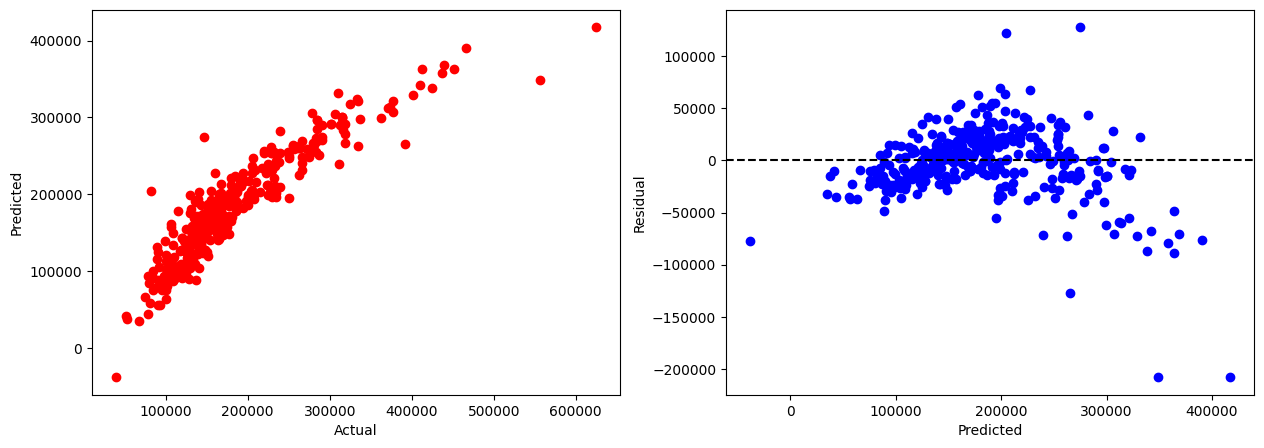

In [211]:
# Actual vs predicted
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred, color= 'red')
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Residual Plot
plt.subplot(1,2,2)
plt.scatter(y_test_pred, y_test_pred-y_test, color= 'blue')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.axhline(y=0, color='black', linestyle='--')

#### Error and Accuracy calculation

In [212]:
mae = mean_absolute_error(y_test,y_test_pred)
print("Average error in my predictions: " + str((mae / y_test.mean()) * 100) + "%")
print("R2_Score of model is:",r2_score(y_test,y_test_pred))

Average error in my predictions: 12.224183583599075%
R2_Score of model is: 0.8394812686405357


#### Saving final predictions

In [ ]:
test_df['SalePrice'] = np.floor(regressor.predict(test_df))
newSubmission = test_df[['Id', 'SalePrice']]
newSubmission.to_csv("newSubmission.csv", index=False)